# Import and pre-definitions

In [ ]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = r'/data'
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
SEED = 42
torch.manual_seed(42)
np.random.seed(42)

True


In [4]:
import sys
sys.path.insert(1, '../..')
sys.path.insert(1, '..')
from utils import measures,metrics
from utils.data_utils import upload_logits,split_data

# Evaluate logits

In [5]:
MODEL_ARC = 'resnet50'
DATASET = 'ImageNet'

METRIC = lambda x,y: metrics.AURC

In [6]:
VAL_SIZE = 0.1
with torch.no_grad():
    logits_v2,labels_v2 = upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'v2', device = dev,data_dir = DATA_PATH)
    risk_v2 = measures.wrong_class(logits_v2,labels_v2).float()
    logits_val,labels_val,logits,labels = split_data.split_logits(*upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'val', device = dev),VAL_SIZE)
    logits_c_val,labels_c_val,logits_c_test,labels_c_test = split_data.split_logits(*upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                                            split = ('corrupted','gaussian_blur',str(3)), device = dev, data_dir = DATA_PATH),VAL_SIZE,seed = SEED)
    risk = measures.wrong_class(logits,labels).float()
    risk_val = measures.wrong_class(logits_val,labels_val).float()

In [7]:
risk_c_val = measures.wrong_class(logits_c_val,labels_c_val).float()
risk_c_test = measures.wrong_class(logits_c_test,labels_c_test).float()

In [8]:
print(f'Test (ID) Accuracy: {100*(1-risk.mean().item()):.2f}')

print(f'ImageNetv2 Accuracy: {100*(1-risk_v2.mean().item()):.2f}')

Test (ID) Accuracy: 80.82
ImageNetv2 Accuracy: 69.87


In [9]:
c,r,t = baseline = metrics.RC_curve(risk,measures.MSP(logits), return_thresholds= True)
c_v2,r_v2,t_v2 = baseline = metrics.RC_curve(risk_v2,measures.MSP(logits_v2), return_thresholds= True)
c_val,r_val,t_val = baseline = metrics.RC_curve(risk_val,measures.MSP(logits_val), return_thresholds= True)
t[-1] = 0; t_v2[-1] = 0; t_val[-1] = 0

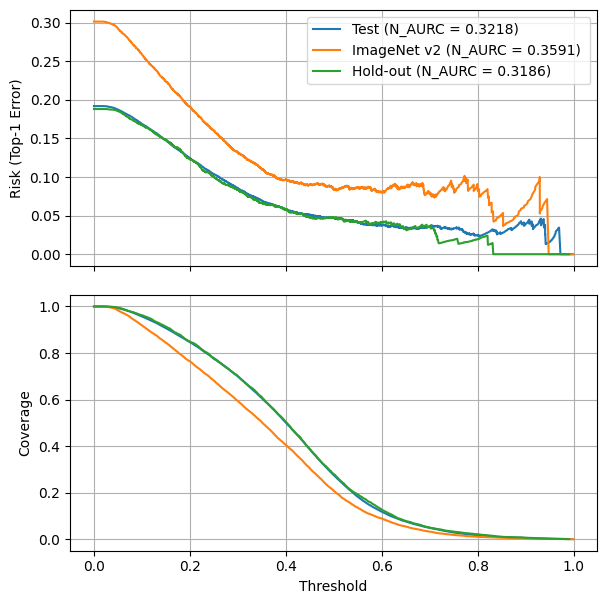

In [10]:
fig,axes = plt.subplots(2,1,figsize = (6,6), sharex = True)
fig.tight_layout()
N_AURC = metrics.N_AURC(risk,measures.MSP(logits))
axes[0].plot(t,r, label  = 'Test'+ f' (N_AURC = {N_AURC:.4f}) ')
axes[1].plot(t,c, label  = 'Test'+ f' (N_AURC = {N_AURC:.4f}) ')
N_AURC = metrics.N_AURC(risk_v2,measures.MSP(logits_v2))
axes[0].plot(t_v2,r_v2, label  = 'ImageNet v2'+ f' (N_AURC = {N_AURC:.4f}) ')
axes[1].plot(t_v2,c_v2, label  = 'ImageNet v2'+ f' (N_AURC = {N_AURC:.4f}) ')
N_AURC = metrics.N_AURC(risk_val,measures.MSP(logits_val))
axes[0].plot(t_val,r_val, label  = 'Hold-out'+ f' (N_AURC = {N_AURC:.4f}) ')
axes[1].plot(t_val,c_val, label  = 'Hold-out'+ f' (N_AURC = {N_AURC:.4f}) ')

axes[1].set_xlabel('Threshold')
axes[0].legend()
axes[0].set_ylabel('Risk (Top-1 Error)')
axes[1].set_ylabel('Coverage')
for ax in axes:
    ax.grid()
    
#plt.savefig(os.path.join(FIGS_PATH, f'RC-{MODEL_ARC}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

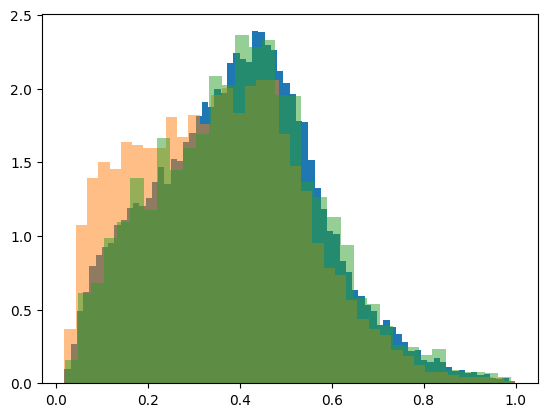

In [11]:
plt.hist(measures.MSP(logits).cpu().numpy(),label = 'g', bins = 'auto', density = True)
plt.hist(measures.MSP(logits_v2).cpu().numpy(),label = 'g_v2', bins = 'auto', density = True, alpha = 0.5)
plt.hist(measures.MSP(logits_val).cpu().numpy(),label = 'g_val', bins = 'auto', density = True, alpha = 0.5)
plt.show()

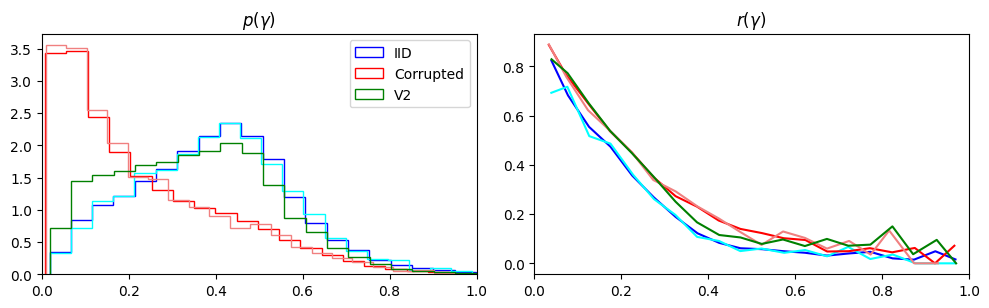

In [31]:
fig,axes = plt.subplots(1,2,figsize = (10,3), sharex = True)
fig.tight_layout()
n_bins = 20
measure = measures.MSP#lambda x: measures.negative_entropy(x).div()
confs, accs = metrics.ReliabilityDiagram(n_bins)(risk,measure(logits))
axes[0].hist(measure(logits).cpu().numpy(), bins = n_bins, density = True,histtype = 'step',color = 'blue',label = 'IID')
axes[1].plot(confs,1-np.array(accs),color = 'blue')

confs, accs = metrics.ReliabilityDiagram(n_bins)(risk_val,measure(logits_val))
axes[0].hist(measure(logits_val).cpu().numpy(), bins = n_bins, density = True,histtype = 'step',color = 'cyan')
axes[1].plot(confs,1-np.array(accs),color = 'cyan')

confs, accs = metrics.ReliabilityDiagram(n_bins)(risk_c_test,measure(logits_c_test))
axes[0].hist(measure(logits_c_test).cpu().numpy(), bins = n_bins, density = True,histtype = 'step',color = 'red',label = 'Corrupted')
axes[1].plot(confs,1-np.array(accs),color = 'red')

confs, accs = metrics.ReliabilityDiagram(n_bins)(risk_c_val,measure(logits_c_val))
axes[0].hist(measure(logits_c_val).cpu().numpy(), bins = n_bins, density = True,histtype = 'step',color = 'lightcoral')
axes[1].plot(confs,1-np.array(accs),color = 'lightcoral')

confs, accs = metrics.ReliabilityDiagram(n_bins)(risk_v2,measure(logits_v2))
axes[0].hist(measure(logits_v2).cpu().numpy(), bins = n_bins, density = True,histtype = 'step',color = 'green',label = 'V2')
axes[1].plot(confs,1-np.array(accs),color = 'green')

axes[0].set_title(r'$p(\gamma)$')
axes[1].set_title(r'$r(\gamma)$')

axes[0].legend()

plt.xlim(0,1)
plt.show()

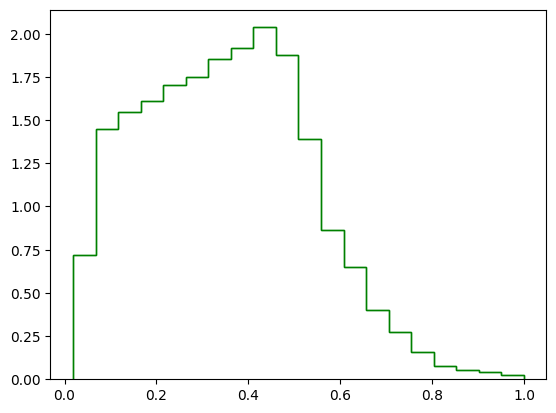

In [13]:
p = plt.hist(measure(logits_v2).cpu().numpy(), bins = n_bins, density = True,histtype = 'step',color = 'green',label = 'V2')[0]
t = plt.hist(measure(logits_v2).cpu().numpy(), bins = n_bins, density = True,histtype = 'step',color = 'green',label = 'V2')[1]

In [14]:
metrics.ECE(n_bins).bin_lowers

tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000,
        0.4500, 0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500,
        0.9000, 0.9500])

In [15]:
metrics.ECE(n_bins).bin_uppers

tensor([0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000, 0.4500,
        0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500, 1.0000])

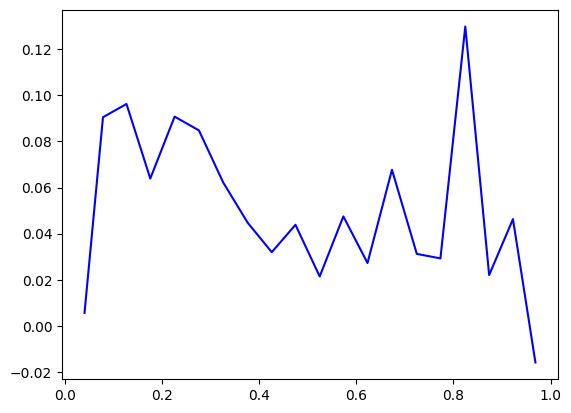

In [16]:
confs_id, accs_id = metrics.ECE(n_bins).diagram(measure(logits),risk)
confs_od, accs_od = metrics.ECE(n_bins).diagram(measure(logits_v2),risk_v2)
#plt.hist(measure(logits).cpu().numpy(), bins = n_bins, density = True,histtype = 'step',color = 'blue',label = 'IID')
plt.plot(confs_id,(-np.array(accs_od)+np.array(accs_id)),color = 'blue')

In [17]:
metric = metrics.ECE(n_bins)
def RC_hypothesis(gamma,risk_gamma_iid,metric = metric):
    b1 = 0
    p_gamma = []
    for b2 in metric.bin_uppers:
        samples = gamma[(gamma>b1).logical_and(gamma<=b2)]
        p_gamma.append(samples.size(0)/gamma.size(0))
        b1 = b2
    risks = []
    coverages = []
    for i,t in enumerate(metric.bin_uppers):
        if i ==0: continue
        c = np.sum(p_gamma[-i:])
        coverages.append(c)
        risks.append((np.array(p_gamma[-i:])*np.array(risk_gamma_iid[-i:])).sum()/c)
    coverages.append(1)
    risks.append((np.array(p_gamma)*np.array(risk_gamma_iid)).sum())
    return coverages,1-np.array(risks)

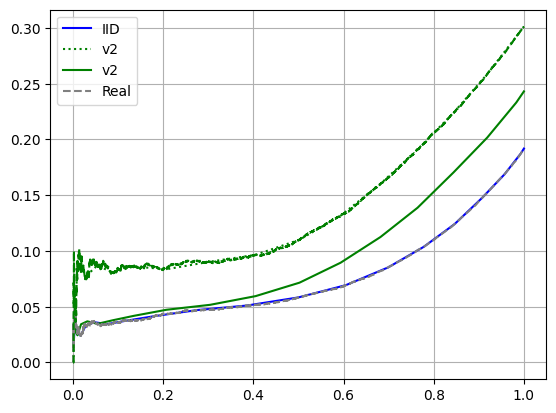

In [18]:
plt.plot(*RC_hypothesis(measures.MSP(logits),np.array(metric.diagram(measures.MSP(logits),risk)[-1])),color = 'blue',label = 'IID')
#plt.plot(*RC_hypothesis(measures.MSP(logits_c_test),np.array(metric.diagram(measures.MSP(logits),risk)[-1])),color = 'red',label = 'corrupted')
plt.plot(*RC_hypothesis(measures.MSP(logits_v2),np.array(metric.diagram(measures.MSP(logits_v2),risk_v2)[-1])),color = 'green',linestyle = ':', label = 'v2')
plt.plot(*RC_hypothesis(measures.MSP(logits_v2),np.array(metric.diagram(measures.MSP(logits),risk)[-1])),color = 'green', label = 'v2')
plt.plot(*metrics.RC_curve(risk,measures.MSP(logits)),color = 'gray',label = 'Real',linestyle = '--')
#plt.plot(*metrics.RC_curve(risk_c_test,measures.MSP(logits_c_test)),color = 'red',linestyle = '--')
plt.plot(*metrics.RC_curve(risk_v2,measures.MSP(logits_v2)),color = 'green',linestyle = '--')
plt.grid()
plt.legend()
plt.show()

In [19]:
delta_r = RC_hypothesis(measures.MSP(logits_v2),np.array(metric.diagram(measures.MSP(logits_v2),risk_v2)[-1]))[1][-1] - RC_hypothesis(measures.MSP(logits_v2),np.array(metric.diagram(measures.MSP(logits),risk)[-1]))[1][-1]

In [20]:
c,RC_h = RC_hypothesis(measures.MSP(logits_v2),np.array(metric.diagram(measures.MSP(logits),risk)[-1]))

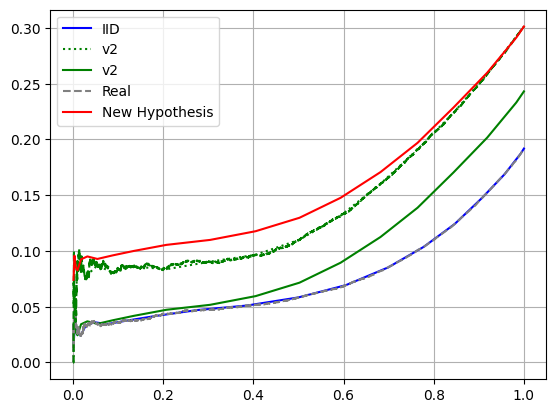

In [21]:
plt.plot(*RC_hypothesis(measures.MSP(logits),np.array(metric.diagram(measures.MSP(logits),risk)[-1])),color = 'blue',label = 'IID')
#plt.plot(*RC_hypothesis(measures.MSP(logits_c_test),np.array(metric.diagram(measures.MSP(logits),risk)[-1])),color = 'red',label = 'corrupted')
plt.plot(*RC_hypothesis(measures.MSP(logits_v2),np.array(metric.diagram(measures.MSP(logits_v2),risk_v2)[-1])),color = 'green',linestyle = ':', label = 'v2')
plt.plot(*RC_hypothesis(measures.MSP(logits_v2),np.array(metric.diagram(measures.MSP(logits),risk)[-1])),color = 'green', label = 'v2')
plt.plot(*metrics.RC_curve(risk,measures.MSP(logits)),color = 'gray',label = 'Real',linestyle = '--')
#plt.plot(*metrics.RC_curve(risk_c_test,measures.MSP(logits_c_test)),color = 'red',linestyle = '--')
plt.plot(*metrics.RC_curve(risk_v2,measures.MSP(logits_v2)),color = 'green',linestyle = '--')
plt.plot(c,np.array(RC_h)+delta_r,color = 'red', label = 'New Hypothesis')
plt.grid()
plt.legend()
plt.show()

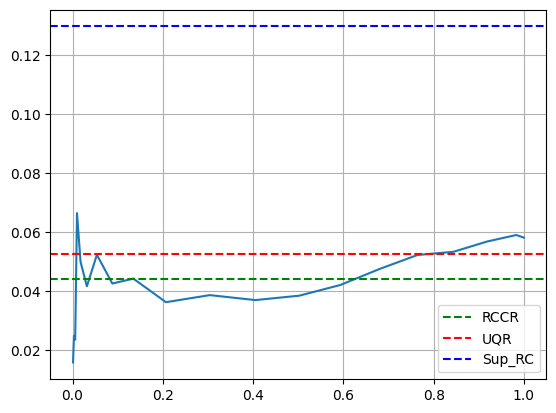

In [22]:
UQR = np.absolute(np.array(metrics.ECE(n_bins).diagram(measure(logits_v2),risk_v2)[1])-np.array(metrics.ECE(n_bins).diagram(measure(logits),risk)[1])).mean()

RC_true = RC_hypothesis(measures.MSP(logits_v2),np.array(metric.diagram(measures.MSP(logits_v2),risk_v2)[-1]))
RC_h = RC_hypothesis(measures.MSP(logits_v2),np.array(metric.diagram(measures.MSP(logits),risk)[-1]))
RCCR = np.absolute(RC_true[1]-RC_h[1]).mean()
plt.plot(RC_true[0],np.absolute(RC_true[1]-RC_h[1]))
plt.axhline(RCCR, label = 'RCCR',linestyle =  '--', color = 'green')
plt.axhline(UQR, label = 'UQR',linestyle =  '--', color = 'red')
plt.axhline(np.absolute(np.array(accs_od)-np.array(accs_id)).max(),color = 'blue',linestyle = '--', label = 'Sup_RC')
plt.legend()
plt.grid()
plt.show()

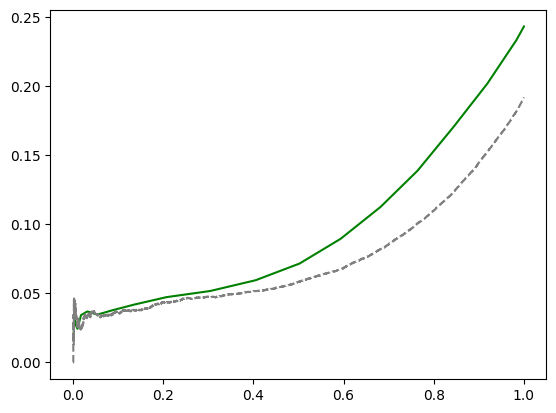

In [23]:
plt.plot(*RC_hypothesis(measures.MSP(logits_v2),np.array(metric.diagram(measures.MSP(logits),risk)[-1])),color = 'green', label = 'v2')
plt.plot(*metrics.RC_curve(risk,measures.MSP(logits)),color = 'gray',label = 'Real',linestyle = '--')

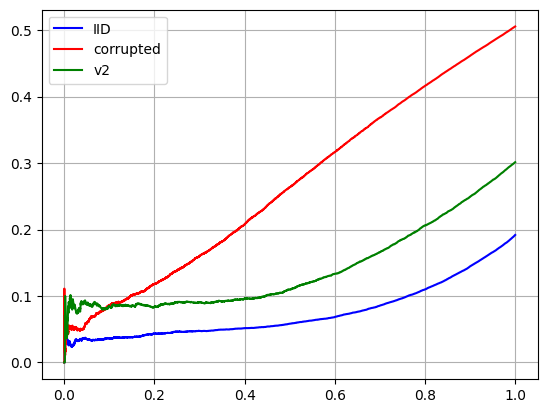

In [24]:
plt.plot(*metrics.RC_curve(risk,measures.MSP(logits)),color = 'blue',label = 'IID')
plt.plot(*metrics.RC_curve(risk_c_test,measures.MSP(logits_c_test)),color = 'red',label = 'corrupted')
plt.plot(*metrics.RC_curve(risk_v2,measures.MSP(logits_v2)),color = 'green', label = 'v2')
plt.grid()
plt.legend()
plt.show()